In [1]:
import os
from collections import Counter
import json
import string

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

import spacy
from spacy.tokens import DocBin
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

REGEX_TOKENIZER = RegexpTokenizer(r'\w+')
STOP_WORDS = set(stopwords.words('english'))
SEED = 2022
nlp = spacy.load("en_core_web_lg")

C:\Users\nazar\AppData\Local\Temp/ipykernel_5532/4229971121.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def remove_stop_words_from_document(doc, tokenizer=REGEX_TOKENIZER, stop_words=STOP_WORDS):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

def remove_punctuation(doc):
    return doc.translate(str.maketrans('', '', string.punctuation))

def lemmatize_text(doc):
    lemmatized = list()
    with nlp.select_pipes(enable="lemmatizer"):
        for token in nlp(doc):
            lemma = token.lemma_.strip()
            lemmatized.append(lemma)
        
    return " ".join(lemmatized)

def preprocess_text(doc, lemmatize=True, tokenizer=REGEX_TOKENIZER, stop_words=STOP_WORDS):
    doc = remove_punctuation(doc)
    doc = remove_stop_words_from_document(doc, REGEX_TOKENIZER, STOP_WORDS)
    if lemmatize:
        doc = lemmatize_text(doc)
    
    return doc

def preprocess_annotations(df):
    accept_mask = df['answer'] == 'accept'
    cols = ['text', 'accept']
    df_prep = df.loc[accept_mask, cols]
    df_prep['accept'] = df_prep['accept'].apply(set)
    df_prep['accept'] = df_prep['accept'].apply(list)
    df_prep.reset_index(drop=True)
    
    return df_prep

def make_docs(data, label_names):
    """
    this will take a list of texts and labels 
    and transform them in spacy documents
    
    data: list(tuple(text, list(labels)))
    
    returns: List(spacy.Doc.doc)
    """
    
    docs = []
    for doc, label_values in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        for label, value in zip(label_names, label_values):
            doc.cats[label] = value
        docs.append(doc)
    
    return docs

In [3]:
fpath = r'C:\ProjectX\workspace\data\data_providers\gdelt\scraped_news\usa-news-annotated.jsonl'
df = pd.read_json(fpath, lines=True, encoding='utf-16')
df.head()

,text,_input_hash,_task_hash,spans,meta,options,accept,_view_id,config,answer,_timestamp
0,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",1998789611,-135893388,"[{'text': 'gun', 'start': 485, 'end': 488, 'pa...","{'pattern': '61, 61, 61, 61, 61, 57, 61, 61, 6...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862735
1,The epic decision by the US Supreme Court decl...,-1364136101,-553694219,"[{'text': 'gun', 'start': 234, 'end': 237, 'pa...","{'pattern': '61, 61, 61'}","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862983
2,"Governor Kathy Hochul has called for an ""extra...",1645904776,555948591,"[{'text': 'gun', 'start': 88, 'end': 91, 'patt...","{'pattern': '61, 58, 61, 60, 61, 60, 60, 58, 5...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863272
3,"CHARLESTON, W.Va. (WV News) -- West Virginia l...",-616248505,-97240494,"[{'text': 'obscene', 'start': 3021, 'end': 302...",{'pattern': '21'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863386
4,"""For the first time now, in this pandemic, nea...",2145160317,1081617857,"[{'text': 'threat', 'start': 1362, 'end': 1368...",{'pattern': '9'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863439


In [4]:
df_prep = preprocess_annotations(df)
#df_prep['text'] = df_prep['text'].apply(preprocess_text)
df_prep.head()

,text,accept
0,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",[]
1,The epic decision by the US Supreme Court decl...,[]
2,"Governor Kathy Hochul has called for an ""extra...",[]
3,"CHARLESTON, W.Va. (WV News) -- West Virginia l...",[]
4,"""For the first time now, in this pandemic, nea...",[]


In [5]:
# remove entries with unique tags to avoid error during train/test split
count_tags = df_prep['accept'].astype(str).value_counts()
mask = df_prep['accept'].astype(str).isin(count_tags[count_tags == 1].index.to_list())
df_prep_unique = df_prep[mask]
df_prep_split = df_prep.loc[~mask, :].copy()

# transofm tags to binary labels
mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(df_prep_split['accept'])
df_prep_split[mlb.classes_] = tags

df_prep_split.tail()

,text,accept,ASSAULT,AUTO_THEFT,HARASSMENT,HOMICIDE,ROBBERY,THEFT
603,Next up in Example video title will go here fo...,[],0,0,0,0,0,0
604,Police arrested a woman last week on suspicion...,[ASSAULT],1,0,0,0,0,0
605,"AMERICAN FORK, Utah -- A man who was at the ce...","[THEFT, ASSAULT]",1,0,0,0,0,1
606,JOHN TOOSON Double homicide suspect John Tooso...,"[HOMICIDE, AUTO_THEFT]",0,1,0,1,0,0
607,A Daviess County deputy has shot a man who ass...,[ASSAULT],1,0,0,0,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df_prep_split['text'].to_list(), tags, train_size=0.75, stratify=tags, random_state=SEED, shuffle=True
)

print(f'train: {len(X_train)} ({len(X_train)/len(df):.0%})\n'
      f'test: {len(X_test)} ({len(X_test)/len(df):.0%})')

train: 393 (65%)
test: 131 (22%)


In [18]:
X_train = X_train + df_prep_unique['text'].to_list()
y_train = np.vstack((y_train, mlb.transform(df_prep_unique['accept'])))

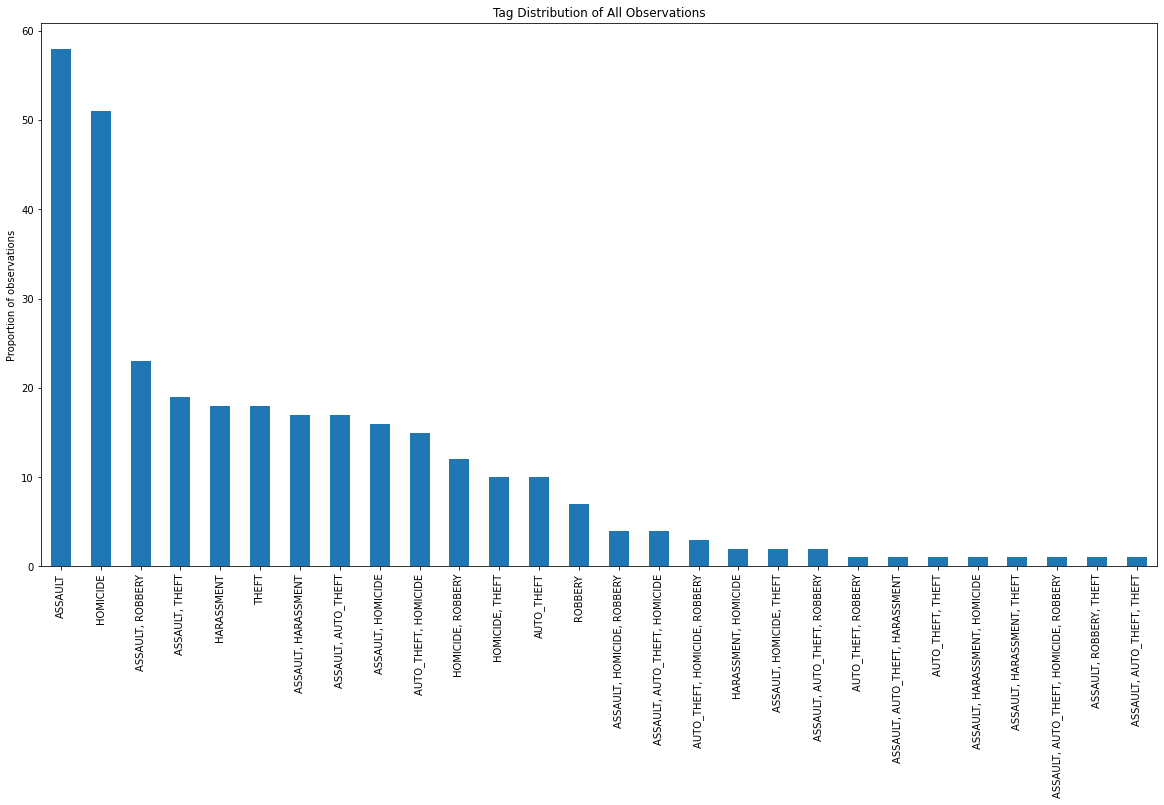

In [19]:
tag_dis = df_prep[df_prep['accept'].astype(str) != '[]']['accept'].apply(lambda x: ', '.join(sorted(tag for tag in x))).value_counts()
tag_dis.plot(
    kind='bar', 
    figsize=(20,10), 
    title='Tag Distribution of All Observations', 
    ylabel='Proportion of observations'
);

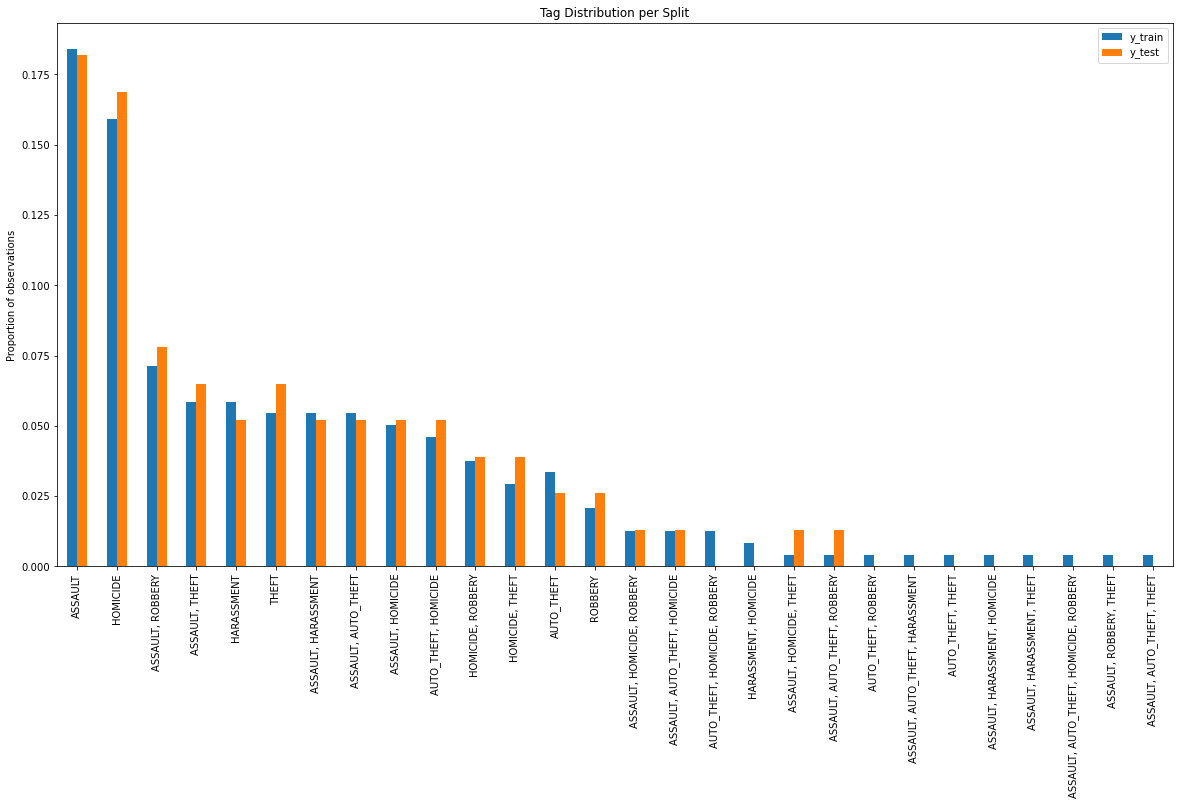

In [20]:
split = pd.DataFrame({
    'y_train': Counter(', '.join(i for i in row) for row in mlb.inverse_transform(y_train)),
    'y_test': Counter(', '.join(i for i in row) for row in mlb.inverse_transform(y_test))
}).reindex(tag_dis.index)

split = split / split.sum(axis=0)
split.plot(
    kind='bar', 
    figsize=(20,10), 
    title='Tag Distribution per Split', 
    ylabel='Proportion of observations'
);

In [21]:
fpath = r'C:\ProjectX\workspace\data\data_providers\gdelt\scraped_news\train_data'

train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

train_docs = make_docs(train_data, mlb.classes_)
test_docs = make_docs(test_data, mlb.classes_)

train_doc_bin = DocBin(docs=train_docs)
train_doc_bin.to_disk(os.path.join(fpath, "train.spacy"))

tets_doc_bin = DocBin(docs=test_docs)
tets_doc_bin.to_disk(os.path.join(fpath, "test.spacy"))

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
model_path = f"C:\ProjectX\workspace\project_x\models\output"

nlp = spacy.load(os.path.join(model_path, "model-last"))

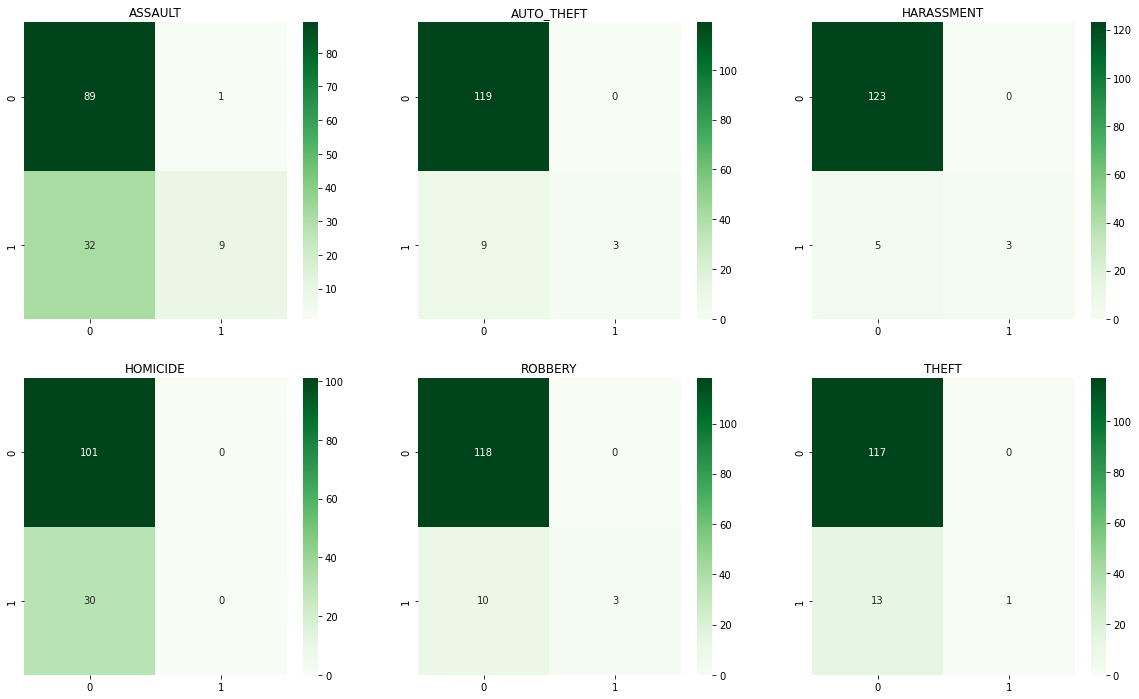

              precision    recall  f1-score   support

     ASSAULT       0.90      0.22      0.35        41
  AUTO_THEFT       1.00      0.25      0.40        12
  HARASSMENT       1.00      0.38      0.55         8
    HOMICIDE       0.00      0.00      0.00        30
     ROBBERY       1.00      0.23      0.38        13
       THEFT       1.00      0.07      0.13        14

   micro avg       0.95      0.16      0.28       118
   macro avg       0.82      0.19      0.30       118
weighted avg       0.71      0.16      0.26       118
 samples avg       0.12      0.10      0.11       118



C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
y_pred = np.array([list(map(int, np.array([*doc.cats.values()]) >= 0.5)) for doc in nlp.pipe(X_test)])
cm = multilabel_confusion_matrix(y_test, y_pred)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

for (i, label), ax in zip(enumerate(mlb.classes_), axs.ravel()):
    #row_sums = cm[i].sum(axis=1) 
    #matrix = (cm[i] / row_sums[:, np.newaxis]).round(4)
    sns.heatmap(cm[i], annot=True, fmt='g', ax=ax, cmap='Greens')

    # chart formatting
    ax.set_title(label)
    #ax.get_legend().remove()
    #ax.set_xlabel("")

plt.show()

print(classification_report(y_test, y_pred, target_names=mlb.classes_))

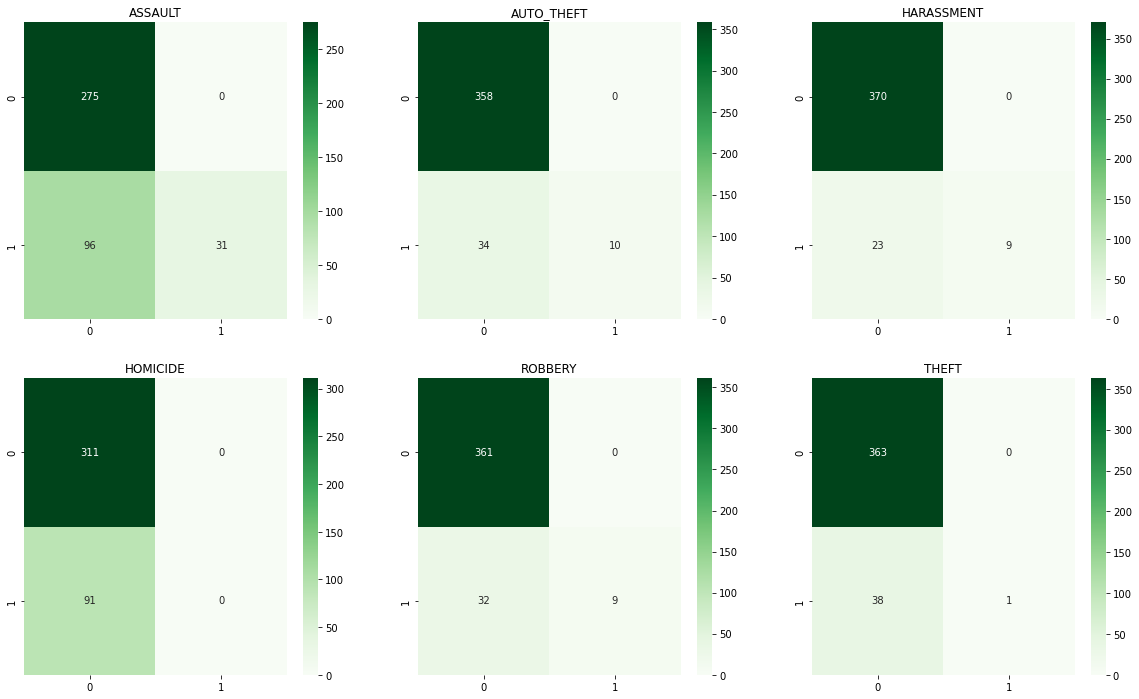

              precision    recall  f1-score   support

     ASSAULT       1.00      0.24      0.39       127
  AUTO_THEFT       1.00      0.23      0.37        44
  HARASSMENT       1.00      0.28      0.44        32
    HOMICIDE       0.00      0.00      0.00        91
     ROBBERY       1.00      0.22      0.36        41
       THEFT       1.00      0.03      0.05        39

   micro avg       1.00      0.16      0.28       374
   macro avg       0.83      0.17      0.27       374
weighted avg       0.76      0.16      0.26       374
 samples avg       0.12      0.09      0.10       374



C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
y_pred_train = np.array([list(map(int, np.array([*doc.cats.values()]) >= 0.5)) for doc in nlp.pipe(X_train)])
cm = multilabel_confusion_matrix(y_train, y_pred_train)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

for (i, label), ax in zip(enumerate(mlb.classes_), axs.ravel()):
    #row_sums = cm[i].sum(axis=1) 
    #matrix = (cm[i] / row_sums[:, np.newaxis]).round(4)
    sns.heatmap(cm[i], annot=True, fmt='g', ax=ax, cmap='Greens')

    # chart formatting
    ax.set_title(label)
    #ax.get_legend().remove()
    #ax.set_xlabel("")

plt.show()

print(classification_report(y_train, y_pred_train, target_names=mlb.classes_))